In [18]:
import numpy as np
from matplotlib import pyplot as plt

import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Normalize
import torch.optim as optim

## Task 1: CNNs for Galaxy Classification

In [2]:
# create data folder if it does not exist
import os
os.makedirs("data", exist_ok=True)

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
    "data/Galaxy10.h5"
)

In [3]:
label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])


### (a)

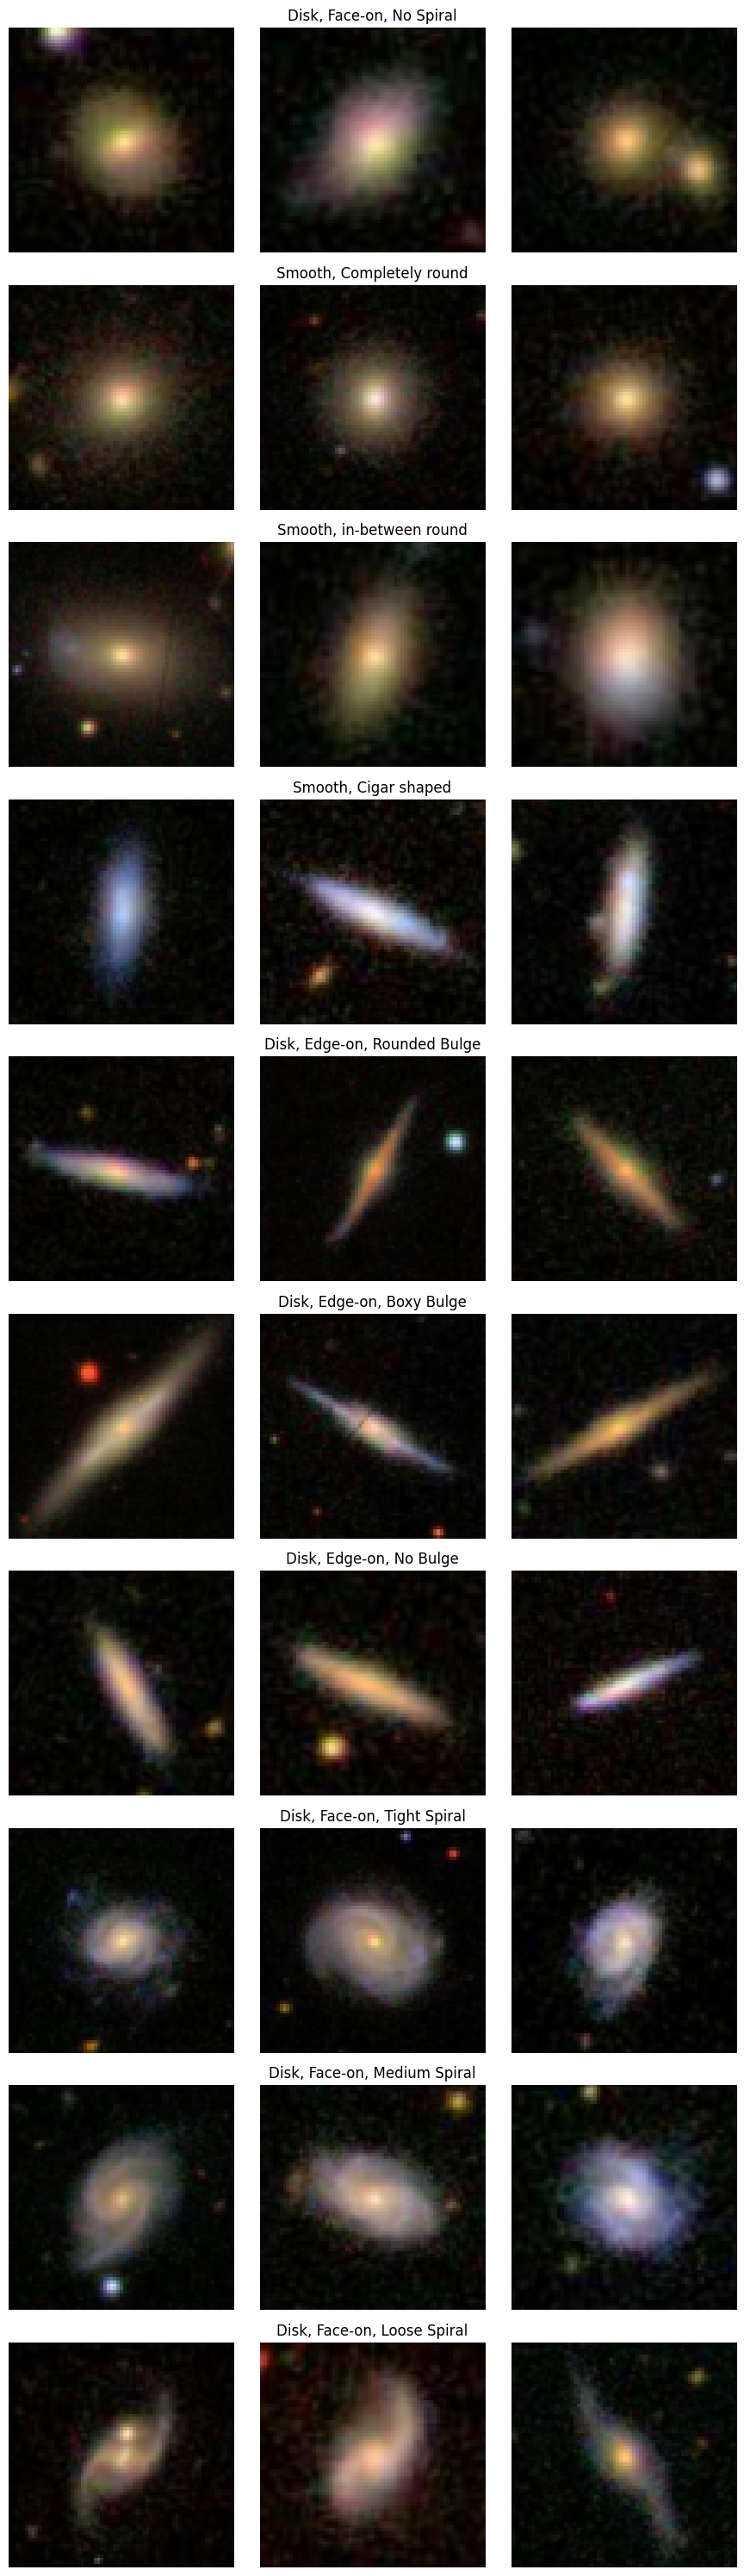

In [11]:
# TODO: plot three samples of each class

# Set up figure
fig, axes = plt.subplots(n_classes, 3, figsize=(9, 3*n_classes))

# For each class
for class_idx in range(n_classes):
    # Get indices of images belonging to this class
    idxs = (labels == class_idx).nonzero(as_tuple=True)[0]
    # Pick 3 random samples
    sample_idxs = idxs[torch.randperm(len(idxs))[:3]]
    
    for i, idx in enumerate(sample_idxs):
        img = images[idx]      # shape: (channels, H, W)
        # move channels to last dim for plotting
        img_np = img.permute(1, 2, 0).numpy()
        # normalize to [0,1] for imshow
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
        
        axes[class_idx, i].imshow(img_np)
        axes[class_idx, i].axis('off')
        if i == 1:
            axes[class_idx, i].set_title(label_names[class_idx])

plt.tight_layout()
plt.show()

   

In [13]:
# TODO: Split the data and normalize the images:


# -----------------------------
# Split into train/test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.33, random_state=42, stratify=labels
)

# -----------------------------
# Normalize images
# -----------------------------
# Compute mean and std per channel from training set
mean = X_train.mean(dim=(0, 2, 3))
std = X_train.std(dim=(0, 2, 3))

# Create a Normalize transform
normalize = Normalize(mean=mean, std=std)

# Apply it to your datasets
X_train_norm = normalize(X_train)
X_test_norm  = normalize(X_test)



# TODO: Create tensordatasets and data loaders:

# -----------------------------
# Create TensorDatasets
# -----------------------------
train_ds = TensorDataset(X_train_norm, y_train)
test_ds  = TensorDataset(X_test_norm, y_test)

# -----------------------------
# Create DataLoaders
# -----------------------------
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_ds)}, Test set size: {len(test_ds)}")
print(f"One batch X shape: {next(iter(train_loader))[0].shape}")

Train set size: 14595, Test set size: 7190
One batch X shape: torch.Size([64, 3, 69, 69])


I have to compute the mean and standard deviation per channel.

### (b)

In [9]:
#TODO: implement a small CNN as specified on the sheet

class GalaxyCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        # Conv layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)   # assuming input 69x69, after 3 poolings ~8x8
        self.fc2 = nn.Linear(128, n_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # Conv + ReLU + Pool
        x = self.pool(F.relu(self.conv1(x)))  # -> 16x34x34
        x = self.pool(F.relu(self.conv2(x)))  # -> 32x17x17
        x = self.pool(F.relu(self.conv3(x)))  # -> 64x8x8
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected + ReLU + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### 

### (c)

In [16]:
# TODO: Instantiate the model, optimizer and criterion

# Model
model = GalaxyCNN()  # your CNN class

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # can tune lr later

# Loss function (criterion)
criterion = nn.CrossEntropyLoss()  # for multi-class classification

### (d)

Val accuracy=0.493, Val loss=1.259e+00
Epoch 1/30 - Train loss=1.430e+00
Val accuracy=0.522, Val loss=1.141e+00
Epoch 2/30 - Train loss=1.142e+00
Val accuracy=0.593, Val loss=1.001e+00
Epoch 3/30 - Train loss=1.029e+00
Val accuracy=0.691, Val loss=8.360e-01
Epoch 4/30 - Train loss=9.280e-01
Val accuracy=0.686, Val loss=8.235e-01
Epoch 5/30 - Train loss=8.227e-01
Val accuracy=0.736, Val loss=7.233e-01
Epoch 6/30 - Train loss=7.651e-01
Val accuracy=0.736, Val loss=7.055e-01
Epoch 7/30 - Train loss=7.090e-01
Val accuracy=0.736, Val loss=7.059e-01
Epoch 8/30 - Train loss=6.578e-01
Val accuracy=0.761, Val loss=6.681e-01
Epoch 9/30 - Train loss=6.144e-01
Val accuracy=0.765, Val loss=6.506e-01
Epoch 10/30 - Train loss=5.707e-01
Val accuracy=0.737, Val loss=7.544e-01
Epoch 11/30 - Train loss=5.347e-01
Val accuracy=0.769, Val loss=6.610e-01
Epoch 12/30 - Train loss=4.986e-01
Val accuracy=0.770, Val loss=6.844e-01
Epoch 13/30 - Train loss=4.888e-01
Val accuracy=0.763, Val loss=7.253e-01
Epoch 14

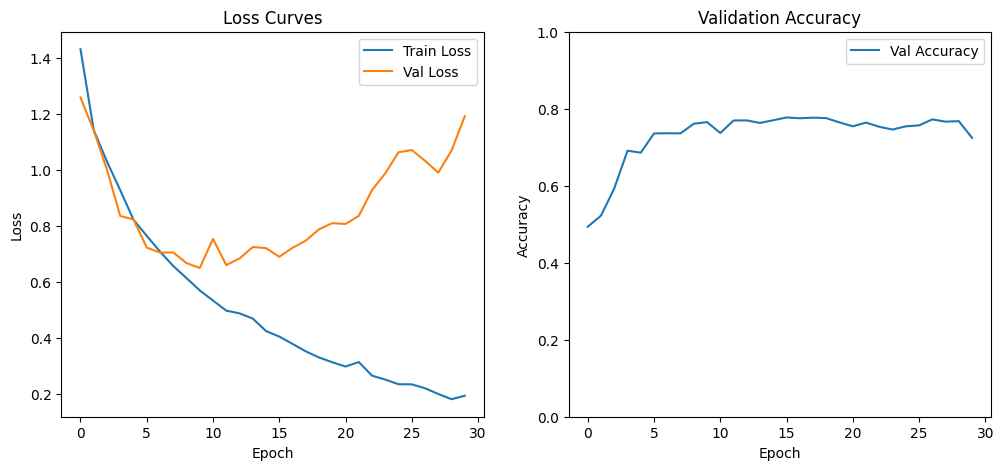

In [17]:

train_losses = []
val_losses = []
val_accs = []

# TODO: Implement the training loop, validating after every epoch, and make the requested plots.

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# -----------------------------
# Validation function
# -----------------------------
def validate(model, loader, criterion):
    model.eval()
    losses = []
    correct = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            losses.append(loss.item() * xb.size(0))
            
            preds = torch.argmax(logits, dim=1)
            correct.append((preds == yb).float().sum().item())
    
    avg_loss = np.sum(losses) / len(loader.dataset)
    accuracy = np.sum(correct) / len(loader.dataset)
    print(f'Val accuracy={accuracy:.3f}, Val loss={avg_loss:.3e}')
    return avg_loss, accuracy

# -----------------------------
# Training loop
# -----------------------------
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    epoch_losses = []
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item() * xb.size(0))
    
    # TODO: Implement the validation loop

    # Average training loss
    train_loss = np.sum(epoch_losses) / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, val_acc = validate(model, test_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{n_epochs} - Train loss={train_loss:.3e}')

# -----------------------------
# Plot loss and accuracy
# -----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()


   

The validation loss increases again due to overtraining of the model.

### (e)

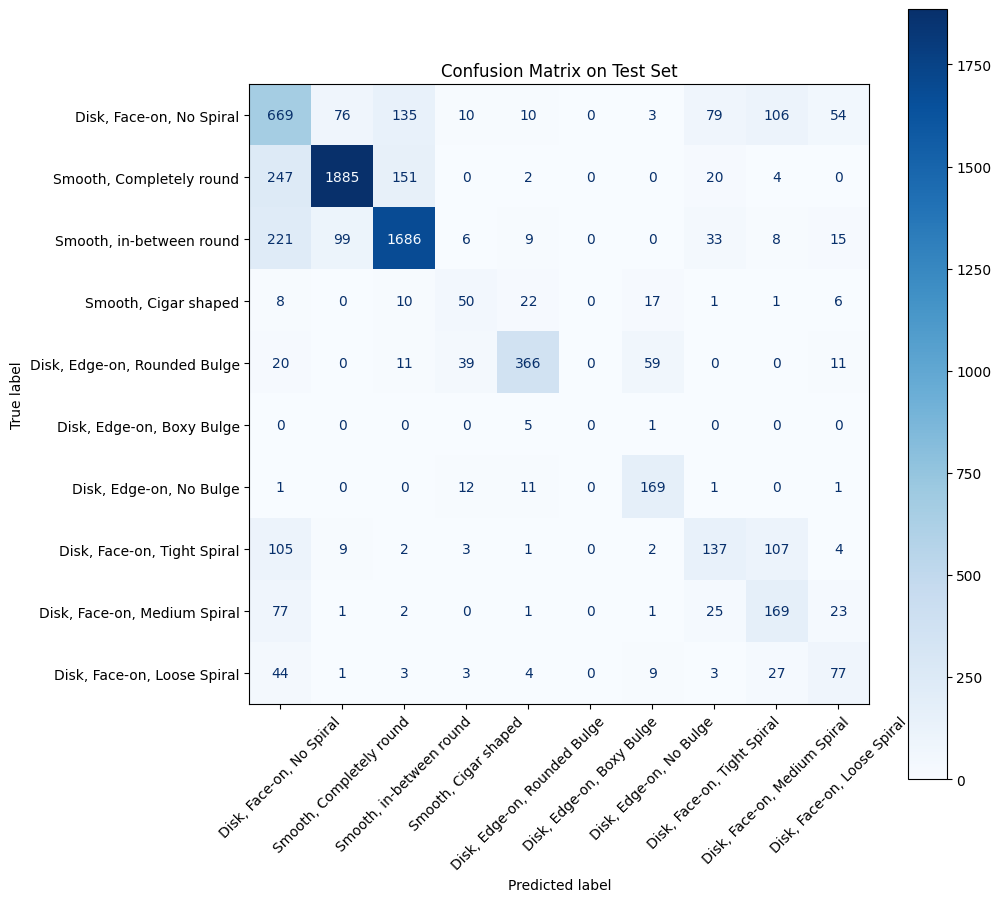

In [19]:
# TODO: Plot the confusion matrix

# Make sure the model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:  # or validation loader
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)             # shape: (batch, n_classes)
        preds = outputs.argmax(dim=1)   # predicted class
        all_preds.append(preds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()

### (f)

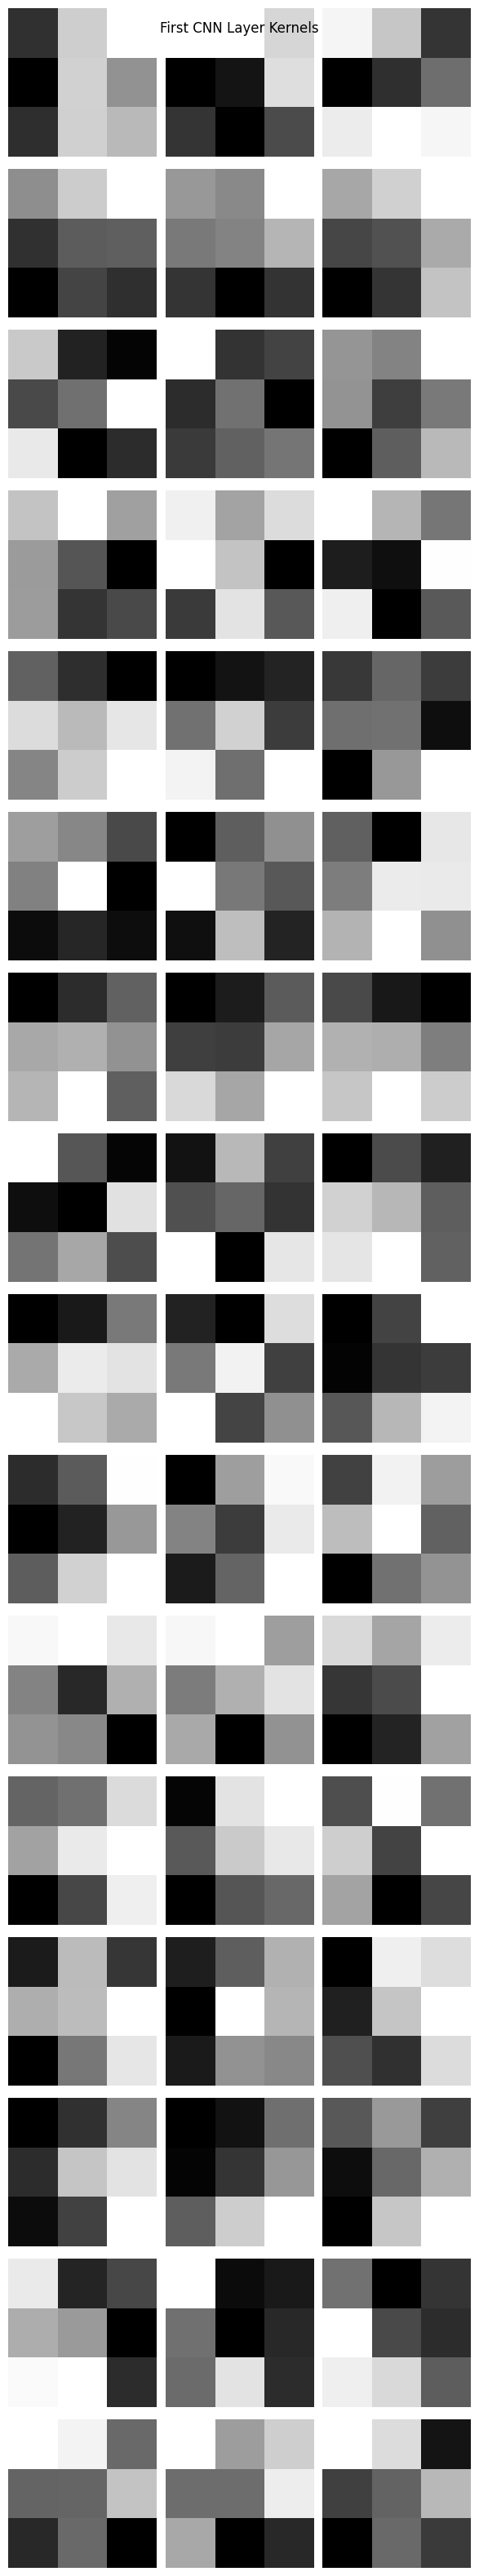

In [20]:
# TODO: Plot the convolutional kernels of the first CNN layer

# Make sure your model is on CPU for plotting
conv1 = model.conv1.weight.detach().cpu()  # shape: (out_channels, in_channels, H, W)

n_kernels = conv1.shape[0]
n_channels = conv1.shape[1]

# Set up the figure
fig, axes = plt.subplots(n_kernels, n_channels, figsize=(n_channels*2, n_kernels*2))

for i in range(n_kernels):
    for j in range(n_channels):
        ax = axes[i, j] if n_kernels > 1 else axes[j]
        # conv1[i,j] has shape (H,W)
        ax.imshow(conv1[i, j], cmap='gray')
        ax.axis('off')

plt.suptitle("First CNN Layer Kernels")
plt.tight_layout()
plt.show()


Each small image you see corresponds to a learned filter in the first CNN layer. The network “slides” this kernel across the input image and computes a weighted sum at every position (this is the convolution).

The pixel intensities in the kernel correspond to weights:
- Bright pixels (positive weights) enhance that part of the input.
- Dark pixels (negative weights) suppress that part of the input.

These kernels are essentially feature detectors. In the first layer, common patterns are edges, colour blobs (if RGB), and simple textures.